# Analysis Template
Purpose is to demonstrate how to use `script.py` and a notebook in conjunction for analysis.<br>
By: Jonathan Lo<br>
Date: 12/1/23


In [43]:
# Imports
import os
import re
import logging
import pandas as pd

from bs4 import BeautifulSoup
from collections import defaultdict

import scipy.stats as stats
from matplotlib import pyplot as plt
import numpy as np

## Loading Data

### Standard `results.csv`

In [44]:
# Example
df = pd.read_csv('results.csv').drop('Unnamed: 0', axis=1)
df.head(3)

,Name,Group,Ad Domain,Ad Title,Ad Link,Race,Sex,Criminal Ad
0,Allison Smith,wf,tracking.truthfinder,‪Public Records Search Engine | Public Records...,https://tracking.truthfinder.com/Public/Records,White,Female,False
1,Allison Smith,wf,tracking.truthfinder,‪Public Records Search Engine | Public Records...,https://tracking.truthfinder.com/Public/Records,White,Female,False
2,Allison Smith,wf,spokeo.com,Search Public Records Online | Lookup Any Pers...,https://www.spokeo.com,White,Female,False


In [45]:
df

,Name,Group,Ad Domain,Ad Title,Ad Link,Race,Sex,Criminal Ad
0,Allison Smith,wf,tracking.truthfinder,‪Public Records Search Engine | Public Records...,https://tracking.truthfinder.com/Public/Records,White,Female,False
1,Allison Smith,wf,tracking.truthfinder,‪Public Records Search Engine | Public Records...,https://tracking.truthfinder.com/Public/Records,White,Female,False
2,Allison Smith,wf,spokeo.com,Search Public Records Online | Lookup Any Pers...,https://www.spokeo.com,White,Female,False
3,Allison Smith,wf,spokeo.com,Search Public Records Online | Lookup Any Pers...,https://www.spokeo.com,White,Female,False
4,Allison Smith,wf,police.us,Public Criminal Records Online | Start Your Se...,https://www.police.us.org/State/Records,White,Female,True
...,...,...,...,...,...,...,...,...
72803,Tyrone Taylor,bm,spokeo.com,Search Public Records - Free | Lookup Public R...,https://www.spokeo.com/Public/Records,Black,Male,False
72804,Tyrone Taylor,bm,police.us,Criminal Records Are Public | [1] Enter Name [...,https://www.police.us.org/State/Records,Black,Male,True
72805,Tyrone Taylor,bm,tracking.truthfinder,‪Police Public Records | Public Records in You...,https://tracking.truthfinder.com/Public/Records,Black,Male,False
72806,Tyrone Taylor,bm,publicrecords.info,State Public Records | US Public Records | Loc...,https://www.publicrecords.info/Public-Records/...,Black,Male,False


## Analysis

In [46]:
# Label
mapping = {'wf': ('White', 'Female'), 'wm': ('White', 'Male'), 'bf': ('Black', 'Female'), 'bm': ('Black', 'Male')}
df['Race'] = df['Group'].map(mapping).str[0]
df['Sex'] = df['Group'].map(mapping).str[1]
df['Criminal Ad'] = df['Ad Title'].str.lower().str.contains('criminal|jail|arrest')

In [47]:
df['Criminal Ad'].value_counts()

Criminal Ad
False    66754
True      6054
Name: count, dtype: int64

In [48]:
# Show breakdowns
counts_r = df.groupby(['Race'])['Name'].count()
counts_rs = df.groupby(['Race', 'Sex'])['Name'].count()
display(counts_r.to_frame())
display(counts_rs.to_frame())

,Name
Race,
Black,36455
White,36353


Name
Race  Sex          
Black Female  18431
      Male    18024
White Female  18498
      Male    17855

In [49]:
breakdown_regular = df.groupby('Group')['Criminal Ad'].count()
only_criminal = df[df['Criminal Ad']]
breakdown_criminal = only_criminal.groupby('Group')['Criminal Ad'].count()
#prep for racial + gender group statistical test

cont_table = [[breakdown_criminal['bf'], breakdown_regular['bf']], 
              [breakdown_criminal['bm'], breakdown_regular['bm']], 
              [breakdown_criminal['wf'], breakdown_regular['wf']], 
              [breakdown_criminal['wm'], breakdown_regular['wm']]]
cont_table

[[1389, 18431], [1677, 18024], [1376, 18498], [1612, 17855]]

In [50]:
#prep for racial group statistical test

obs = [df.groupby('Race')['Criminal Ad'].count()['Black'], df.groupby('Race')['Criminal Ad'].count()['White']]
successes = [only_criminal.groupby('Race')['Criminal Ad'].count()['Black'], only_criminal.groupby('Race')['Criminal Ad'].count()['White']]

In [51]:
#prep for gender group statistical test

obs_gender = [df.groupby('Sex')['Criminal Ad'].count()['Female'], df.groupby('Sex')['Criminal Ad'].count()['Male']]
successes_gender = [only_criminal.groupby('Sex')['Criminal Ad'].count()['Female'], only_criminal.groupby('Sex')['Criminal Ad'].count()['Male']]

Grouped by race and gender:
With a p-value of 0.0, we reject the null hypothesis. There is statistically significant difference between the proportions.


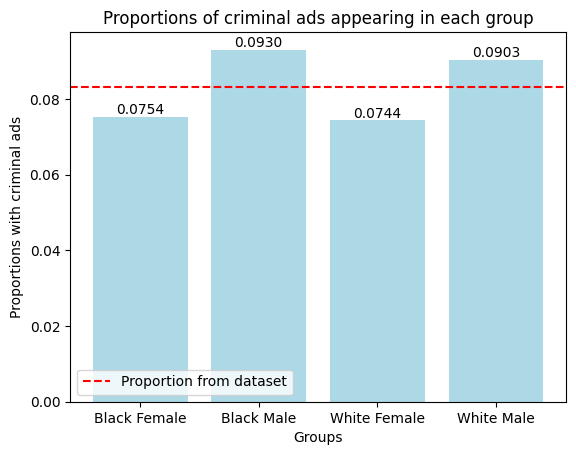

In [52]:
#Chi-Square Test
#To compare the rates of criminal ads and regular ads shown to each gender + racial group.


#Null Hypothesis: All four proportions come from the same distribution (i.e. they are equal)
#Alternative Hypothesis: All four proportions are not the same.


chi2, p, dof, expected = stats.chi2_contingency(cont_table)
if p < 0.05:
    print(f"Grouped by race and gender:\nWith a p-value of {round(p, 3)}, we reject the null hypothesis. There is statistically significant difference between the proportions.")
else:
    print(f"Grouped by race and gender:\nWith a p-value of {round(p, 3)}, we fail to reject the null hypothesis. There is no statistically significant difference in the proportions.")
proportions = [(breakdown_criminal['bf'] / breakdown_regular['bf']), (breakdown_criminal['bm'] / breakdown_regular['bm']), (breakdown_criminal['wf'] / breakdown_regular['wf']), (breakdown_criminal['wm']/breakdown_regular['wm'])]  
group_labels = ['Black Female', 'Black Male', 'White Female', 'White Male']
overall_prop = len(only_criminal) / len(df)
plt.bar(group_labels, proportions, color='lightblue')
plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion from dataset')
for i in range(len(group_labels)):
    plt.text(i, proportions[i], f'{proportions[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Groups')
plt.ylabel('Proportions with criminal ads')
plt.title('Proportions of criminal ads appearing in each group')
plt.legend(loc='lower left')
plt.show()

In [53]:
def two_prop_z_test(s, o):
    p1 = s[0] / o[0]
    p2 = s[1] / o[1]
    pooled_p = np.sum(s) / np.sum(o)
    se = np.sqrt(pooled_p * (1 - pooled_p) * ((1 / o[0]) + (1 / o[1])))
    z = (p1 - p2) / se
    p_val = 2 * (1 - stats.norm.cdf(np.abs(z)))
    return p_val

Grouped by race:
With a p-value of 0.351, we fail to reject the null hypothesis. There is no statistically significant difference between the two proportions.


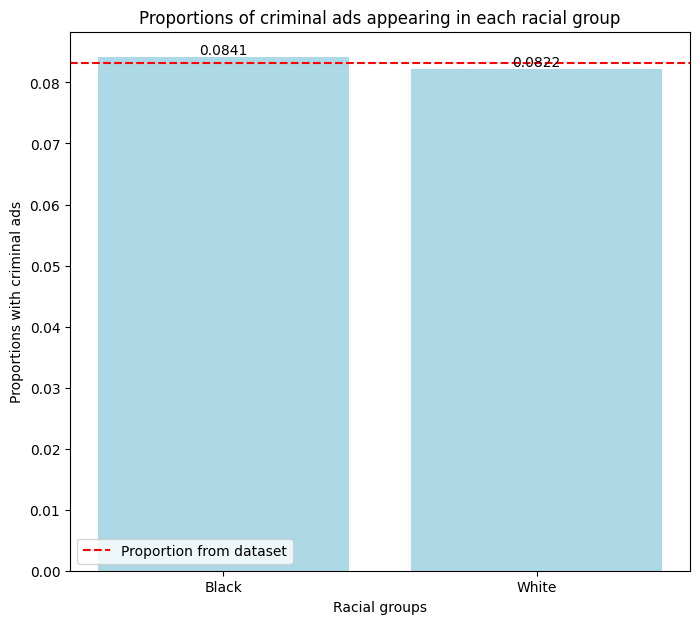

In [54]:
#Two-Proportion Z Test
#To compare just racial groups criminal ads vs. regular ads


#Null Hypothesis: The two proportions are the same
#Alternative Hypothesis: The two proportions are different


p_val = two_prop_z_test(successes, obs)
if p_val < 0.05:
    print(f"Grouped by race:\nWith a p-value of {round(p_val, 3)}, we reject the null hypothesis. There is a statistically significant difference between the two proportions.")
else:
    print(f"Grouped by race:\nWith a p-value of {round(p_val, 3)}, we fail to reject the null hypothesis. There is no statistically significant difference between the two proportions.")
    
black_prop = successes[0] / obs[0]
white_prop = successes[1] / obs[1]
racial_props = [black_prop, white_prop]
racial_groups = ['Black', 'White']
fig = plt.figure(figsize=(8,7))

plt.bar(racial_groups, racial_props, color='lightblue')
plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion from dataset')
for i in range(len(racial_groups)):
    plt.text(i, racial_props[i], f'{racial_props[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Racial groups')
plt.ylabel('Proportions with criminal ads')
plt.title('Proportions of criminal ads appearing in each racial group')
plt.legend(loc='lower left')
plt.show()

Grouped by gender:
With a p-value of 0.0, we reject the null hypothesis. There is a statistically significant difference between the two proportions.


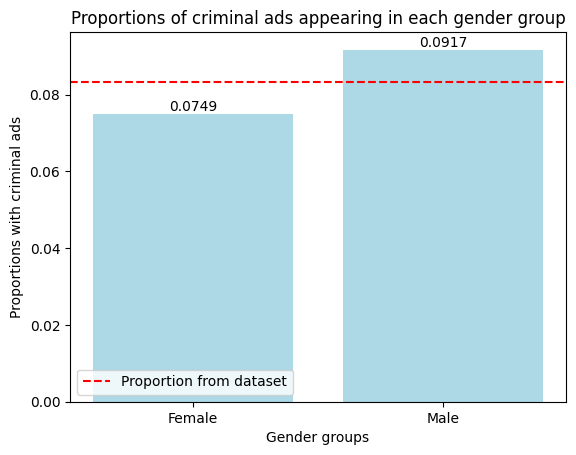

In [55]:
#Two-Proportion Z Test
#To compare just gender groups criminal ads vs. regular ads


#Null Hypothesis: The two proportions are the same
#Alternative Hypothesis: The two proportions are different


p_val2 = two_prop_z_test(successes_gender, obs_gender)
if p_val2 < 0.05:
    print(f"Grouped by gender:\nWith a p-value of {round(p_val2, 3)}, we reject the null hypothesis. There is a statistically significant difference between the two proportions.")
else:
    print(f"Grouped by gender:\nWith a p-value of {round(p_val2, 3)}, we fail to reject the null hypothesis. There is no statistically significant difference between the two proportions.")
female_prop = successes_gender[0] / obs_gender[0]
male_prop = successes_gender[1] / obs_gender[1]
gender_props = [female_prop, male_prop]
gender_groups = ['Female', 'Male']

plt.bar(gender_groups, gender_props, color='lightblue')
plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion from dataset')
for i in range(len(gender_groups)):
    plt.text(i, gender_props[i], f'{gender_props[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Gender groups')
plt.ylabel('Proportions with criminal ads')
plt.title('Proportions of criminal ads appearing in each gender group')
plt.legend(loc='lower left')
plt.show()

Ad Domain: spokeo.com
17471 ads from this domain
chi p: 1.0569735498987922e-06


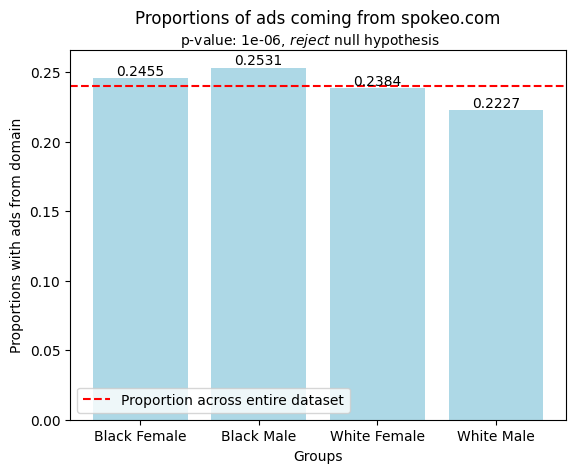

gender p: 0.21443670065830212


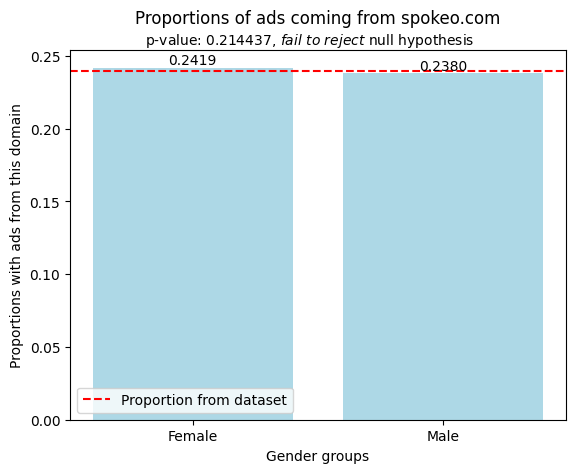

racial p: 4.3336947364e-09


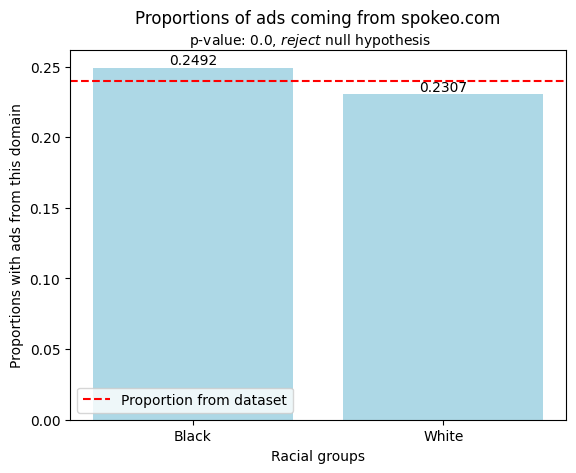

Ad Domain: publicrecords.info
11545 ads from this domain
chi p: 5.416736921432548e-65


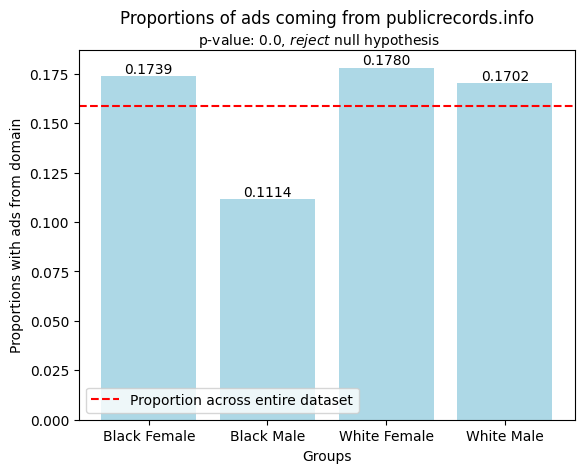

gender p: 0.0


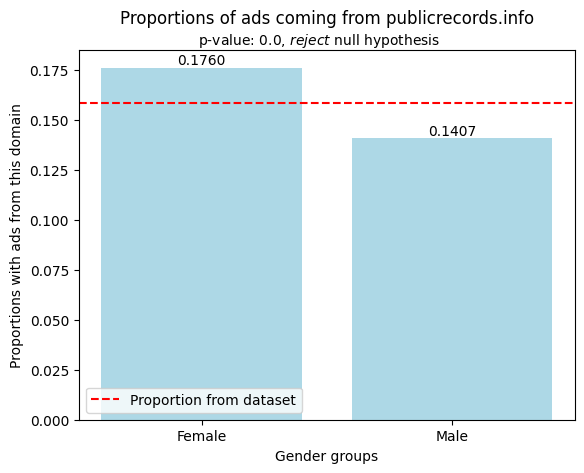

racial p: 0.0


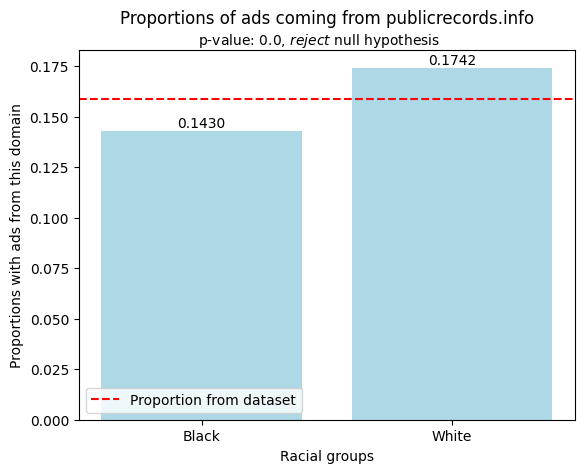

Ad Domain: tracking.truthfinder
10540 ads from this domain
chi p: 3.900751812121354e-31


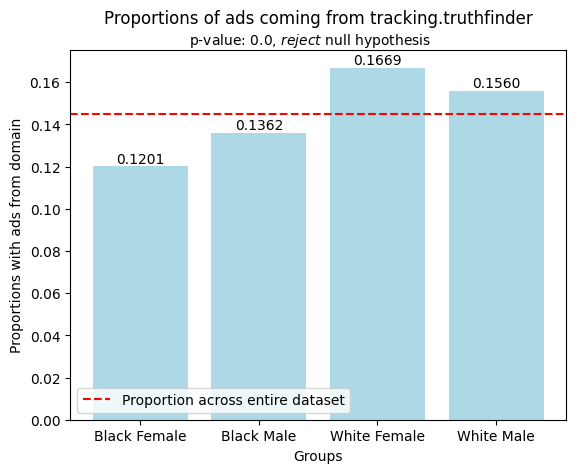

gender p: 0.33248069509375044


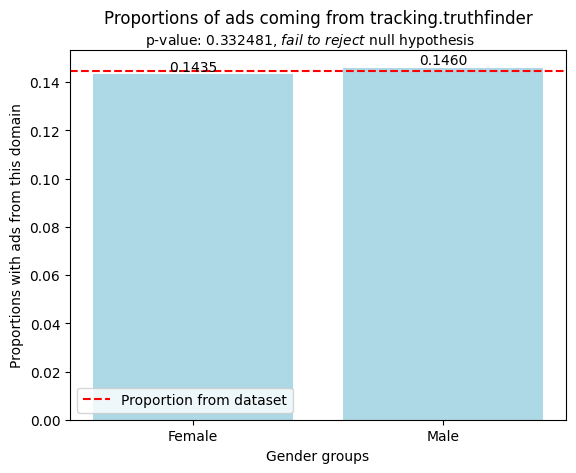

racial p: 0.0


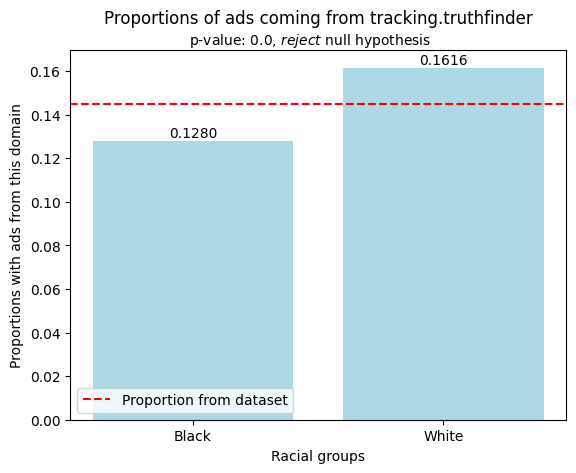

Ad Domain: police.us
10184 ads from this domain
chi p: 4.061793469298437e-24


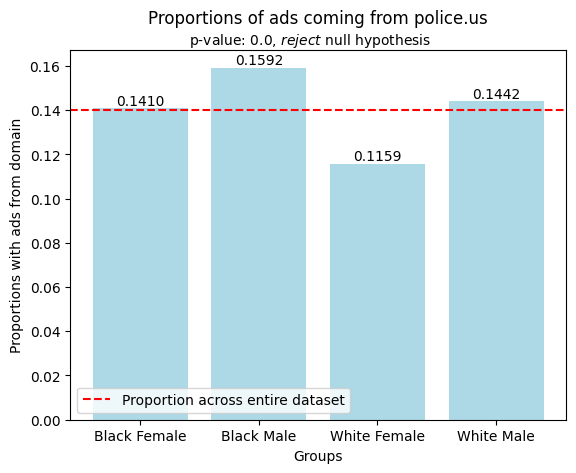

gender p: 0.0


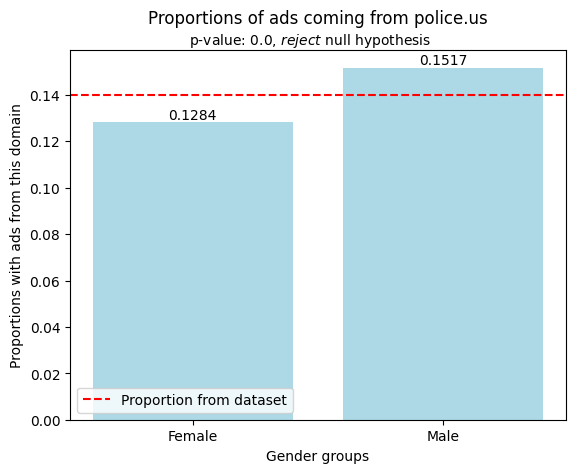

racial p: 3.77476e-15


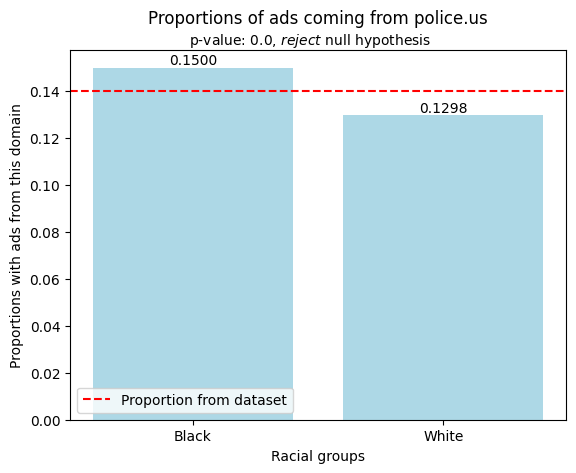

In [56]:
#  same hypothesis tests for the top 4 ad domains represented in the dataset.

#  A rejection of the null hypothesis means that this ad domain is over/under representing a gender, racial,
#  or combined gender + racial group based on what was seen in the original dataset.

#  For example, if we reject the null hypothesis for the domain spokeo.com and the racial grouping, this means
#  spokeo.com has a statistically significantly higher proportion of ads for one racial group (black or white) 
#  than the proportion that was seen in the original dataset.

#  A fail to reject result means that no significant difference was detected between the distribution of ads that
#  just appeared from this domain and the distribution that appeared in the original dataset.



for i in df['Ad Domain'].value_counts().index[:4]:
    print(f"\033[1mAd Domain: {i}\033[0m")
    
    #prep for both two-prop z tests
    df_filt = df[df['Ad Domain'] == i]
    print(f"{len(df_filt)} ads from this domain")
    racial_obs = [df.groupby('Race')['Criminal Ad'].count()['Black'], df.groupby('Race')['Criminal Ad'].count()['White']]
    racial_successes = [df_filt.groupby('Race')['Criminal Ad'].count()['Black'], df_filt.groupby('Race')['Criminal Ad'].count()['White']]
    gender_obs = [df.groupby('Sex')['Criminal Ad'].count()['Female'], df.groupby('Sex')['Criminal Ad'].count()['Male']]
    gender_successes = [df_filt.groupby('Sex')['Criminal Ad'].count()['Female'], df_filt.groupby('Sex')['Criminal Ad'].count()['Male']]
    
    #prep for chi-square test
    breakdown_regular = df.groupby('Group')['Criminal Ad'].count()
    breakdown_domain = df_filt.groupby('Group')['Criminal Ad'].count()
    cont_table = [[breakdown_domain['bf'], breakdown_regular['bf']], 
              [breakdown_domain['bm'], breakdown_regular['bm']], 
              [breakdown_domain['wf'], breakdown_regular['wf']], 
              [breakdown_domain['wm'], breakdown_regular['wm']]]
    
    #chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(cont_table)
    print('chi p: '+ str(p))
    
    #make plot to show race + gender group breakdowns
    proportions = [(breakdown_domain['bf'] / breakdown_regular['bf']), (breakdown_domain['bm'] / breakdown_regular['bm']), (breakdown_domain['wf'] / breakdown_regular['wf']), (breakdown_domain['wm']/breakdown_regular['wm'])]  
    group_labels = ['Black Female', 'Black Male', 'White Female', 'White Male']
    overall_prop = len(df_filt) / len(df)
    plt.bar(group_labels, proportions, color='lightblue')
    plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion across entire dataset')
    for j in range(len(group_labels)):
        plt.text(j, proportions[j], f'{proportions[j]:.4f}', ha='center', va='bottom')
    plt.xlabel('Groups')
    plt.ylabel('Proportions with ads from domain')
    plt.title(f'Proportions of ads coming from {i}', y=1.05)
    if p < 0.05:
        plt.suptitle(f'p-value: {round(p, 6)}, $reject$ null hypothesis', y=0.92, fontsize=10)
    else:
        plt.suptitle(f'p-value: {round(p, 6)}, $fail$ $to$ $reject$ null hypothesis', y=0.92, fontsize=10)
    plt.legend(loc='lower left')
    plt.show()
        
    #both two-prop z tests for difference between just gender and just racial groups
    
    gender_p = two_prop_z_test(gender_successes, gender_obs)
    
    print('gender p: '+str(round(gender_p, 20)))
    
    gender_props = [(gender_successes[0] / gender_obs[0]), (gender_successes[1] / gender_obs[1])]
    gender_groups = ['Female', 'Male']
    plt.bar(gender_groups, gender_props, color='lightblue')
    plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion from dataset')
    for j in range(len(gender_groups)):
        plt.text(j, gender_props[j], f'{gender_props[j]:.4f}', ha='center', va='bottom')
    plt.xlabel('Gender groups')
    plt.ylabel('Proportions with ads from this domain')
    plt.title(f'Proportions of ads coming from {i}', y=1.05)
    if gender_p < 0.05:
        plt.suptitle(f'p-value: {round(gender_p, 6)}, $reject$ null hypothesis', y=0.92, fontsize=10)
    else:
        plt.suptitle(f'p-value: {round(gender_p, 6)}, $fail$ $to$ $reject$ null hypothesis', y=0.92, fontsize=10)

    plt.legend(loc='lower left')
    plt.show()
            
    racial_p = two_prop_z_test(racial_successes, racial_obs)
    
    print('racial p: '+ str(round(racial_p, 20)))
    
    racial_props = [(racial_successes[0] / racial_obs[0]), (racial_successes[1] / racial_obs[1])]
    racial_groups = ['Black', 'White']
    
    plt.bar(racial_groups, racial_props, color='lightblue')
    plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion from dataset')
    for j in range(len(racial_groups)):
        plt.text(j, racial_props[j], f'{racial_props[j]:.4f}', ha='center', va='bottom')
    plt.xlabel('Racial groups')
    plt.ylabel('Proportions with ads from this domain')
    plt.title(f'Proportions of ads coming from {i}', y=1.05)
    if racial_p < 0.05:
        plt.suptitle(f'p-value: {round(racial_p, 6)}, $reject$ null hypothesis', y=0.92, fontsize=10)
    else:
        plt.suptitle(f'p-value: {round(racial_p, 6)}, $fail$ $to$ $reject$ null hypothesis', y=0.92, fontsize=10)
    plt.legend(loc='lower left')
    plt.show()

In [57]:
len(df['Ad Domain'].value_counts(dropna=False))

55

In [31]:
only_crim = df[df['Criminal Ad']]

In [41]:
only_crim['Ad Domain'].value_counts(dropna=False)

Ad Domain
police.us                    5112
tracking.truthfinder          635
tracking.instantcheckmate     115
criminalrecords.us             67
corragroup.com                 45
ourpublicrecords.org           29
publicrecords.report           29
top10.com                      12
searchpublicrecords.com         6
apple.com                       4
Name: count, dtype: int64

In [42]:
df[df['Ad Domain'] == 'apple.com']

,Name,Group,Ad Domain,Ad Title,Ad Link,Race,Sex,Criminal Ad
45230,Diamond Thomas,bf,apple.com,Criminal Record - Apple TV+ - Official trailer,www.apple.com,Black,Female,True
45244,Diamond Thomas,bf,apple.com,Criminal Record - Apple TV+ - Official trailer,www.apple.com,Black,Female,True
60969,Leroy Thomas,bm,apple.com,Criminal Record | Apple TV+,www.apple.com,Black,Male,True
60982,Leroy Thomas,bm,apple.com,Criminal Record | Apple TV+,www.apple.com,Black,Male,True


In [38]:
5112 / 6054

0.844400396432111